In [563]:
import laspy
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import random

In [564]:
las = laspy.read('banska5.las')

print(list(las.point_format.dimension_names))
print(set(list(las.classification)))

vsetky_data = np.stack([las.X,las.Y,las.Z], axis = 0).transpose((1,0))
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(vsetky_data)
print(len(np.array(geom.points)))
o3d.visualization.draw_geometries([geom])

['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time']
{1, 2, 3, 4, 5, 6, 7, 18}
727756


In [565]:
las = las[las.classification == 5] # stromy
stromy = np.stack([las.X,las.Y,las.intensity], axis = 0).transpose((1,0))
geom.points = o3d.utility.Vector3dVector(stromy)
o3d.visualization.draw_geometries([geom])

In [566]:
geom = geom.remove_radius_outlier(3,1000)[0]
o3d.visualization.draw_geometries([geom])

In [567]:
"""
najlepsie = 100000000
pocet_bodov = len(np.array(geom.points))
print(pocet_bodov)
pocet_tried = pocet_bodov
minus_jednotky_v_triedach = True
while  najlepsie!=0 and pocet_tried>pocet_bodov //10:
    nedefinovane = najlepsie
    eps = random.randint(10,500)
    min_points = random.randint(1,30)
    labels = np.array(geom.cluster_dbscan(eps, min_points))
    nedefinovane = labels.tolist().count(-1)
    pocet_tried = len(set(labels))
    if nedefinovane < najlepsie:
        najlepsie = nedefinovane
        print(najlepsie)
"""

'\nnajlepsie = 100000000\npocet_bodov = len(np.array(geom.points))\nprint(pocet_bodov)\npocet_tried = pocet_bodov\nminus_jednotky_v_triedach = True\nwhile  najlepsie!=0 and pocet_tried>pocet_bodov //10:\n    nedefinovane = najlepsie\n    eps = random.randint(10,500)\n    min_points = random.randint(1,30)\n    labels = np.array(geom.cluster_dbscan(eps, min_points))\n    nedefinovane = labels.tolist().count(-1)\n    pocet_tried = len(set(labels))\n    if nedefinovane < najlepsie:\n        najlepsie = nedefinovane\n        print(najlepsie)\n'

In [568]:
print("POCET BODOV V STROMOCH:",len(np.array(geom.points)))
while True:
    eps = random.randint(100,300)
    min_points = random.randint(1,20)
    labels = np.array(geom.cluster_dbscan(eps, min_points))
    pocet_minus_jednotiek_v_triedach = labels.tolist().count(-1)
    minus_jednotky_v_triedach = labels.tolist().count(-1) > 0
    pocet_tried = len(set(labels))
    pocty_bodov_v_triedach = [np.count_nonzero(labels == x) for x in set(labels)]
    if minus_jednotky_v_triedach == False and  pocet_tried < len(np.array(geom.points)) // 100:
    #if minus_jednotky_v_triedach == False and  min(pocty_bodov_v_triedach) >=3:
    #if pocet_minus_jednotiek_v_triedach< len(np.array(geom.points)) // 10  and pocet_tried < len(np.array(geom.points)) // 100 and min(pocty_bodov_v_triedach) >=10:
        break
print(eps, min_points)
labels

POCET BODOV V STROMOCH: 33514
282 1


array([  0,   0,   0, ..., 227, 228, 229], dtype=int32)

In [569]:
#ODSTRAN -1 a oprav indexy labelov
#outlayer_indexes = [x for x in labels if x == -1]
#labels = np.array([x for index,x in enumerate(labels) if index not in outlayer_indexes])
#geom.points = o3d.utility.Vector3dVector(np.array([x for index,x in enumerate(np.array(geom.points)) if index not in outlayer_indexes]))

In [570]:
#ODSTRAN male clustre
print(len(np.array(geom.points)))
print(len(labels))


outlayer_indexes = [index for index,x in enumerate(labels) if np.count_nonzero(labels ==x)<3]
labels = np.array([x for index,x in enumerate(labels) if index not in outlayer_indexes])


a = np.array(geom.points)
b  = np.array([x for index,x in enumerate(np.array(geom.points)) if index not in outlayer_indexes])
geom.points = o3d.utility.Vector3dVector(b)
print(len(np.array(geom.points)))
print(len(labels))


33514
33514
33408
33408


In [571]:
if -1 in labels:
    raise Exception("-1")

In [572]:
#KAZDY CLUSTER INA FARBA
random_colors = []
for label in labels:
    if label == -1:
        random_colors.append([0,0,0])
    else:    
        random_colors.append([random.random()*0.8 +0.2,random.random()*0.8 +0.2,random.random()*0.8 +0.2])
colors = [random_colors[x] for x in labels]
geom.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([geom])

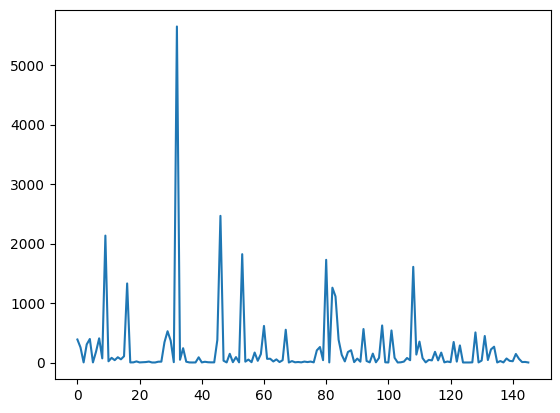

In [573]:
# POCTY BODOV V ZHLUKOCH BEZ ZHLUKU -1
pocty = []
for i in set(labels):
   pocty.append((i, labels.tolist().count(i)))
plt.figure()
plt.plot([x for x in range(len(pocty))],[x[1] for x in pocty])
plt.show()

In [574]:
# CLUSTRE S POCTOM BODOV VACSIM AKO PRIEMER
najvacsie_po_najmensie = sorted(pocty,key=lambda x: x[1],reverse=True)
hodnoty_najvacsie_po_najmensie = [x[1] for x in najvacsie_po_najmensie]
priemer = np.average(hodnoty_najvacsie_po_najmensie) 
nadpriemerne_indexy_tried = [x[0] for x in najvacsie_po_najmensie if x[1] > priemer*2]
nadpriemerne_body = []
for index,bod in enumerate(np.array(geom.points)):
    if labels[index] in nadpriemerne_indexy_tried:
        nadpriemerne_body.append(bod)
geom.points = o3d.utility.Vector3dVector(nadpriemerne_body)
o3d.visualization.draw_geometries([geom])


In [575]:
najvacsie_clustre = []
for _ in range(len(nadpriemerne_indexy_tried)):
    indexy_aktualneho_clustera = [x for x in range(len(np.array(geom.points))) if labels[x] == nadpriemerne_indexy_tried[_]]
    if(len(indexy_aktualneho_clustera) > 0):
        najvacsie_clustre.append(np.array(geom.points)[indexy_aktualneho_clustera])

print(len(najvacsie_clustre))
for index,cluster in enumerate(najvacsie_clustre):
    if cluster in najvacsie_clustre[index:-1]:
        najvacsie_clustre.remove(cluster)
print(len(najvacsie_clustre))

for cluster in najvacsie_clustre:
    cluster = np.array(cluster)
    print(len(cluster))
    geom.points = o3d.utility.Vector3dVector(cluster)
    minus_jednotky_v_triedach = True
    while True:
        eps = random.randint(10,200)
        min_points = random.randint(1,20)
        labels = np.array(geom.cluster_dbscan(eps, min_points))
        minus_jednotky_v_triedach = labels.tolist().count(-1) > 0
        pocet_tried = len(set(labels))
        pocty_bodov_v_triedach = [np.count_nonzero(labels == x) for x in set(labels)]
        #if minus_jednotky_v_triedach == False and  pocet_tried < len(cluster) // 10 and min(pocty_bodov_v_triedach) >=3:
        if minus_jednotky_v_triedach == False and  pocet_tried < len(cluster) // 10:
            break
    #ODSTRAN male clustre
    print(len(np.array(geom.points)))
    print(len(labels))


    outlayer_indexes = [index for index,x in enumerate(labels) if np.count_nonzero(labels ==x)<10]
    labels = np.array([x for index,x in enumerate(labels) if index not in outlayer_indexes])


    a = np.array(geom.points)
    b  = np.array([x for index,x in enumerate(np.array(geom.points)) if index not in outlayer_indexes])
    geom.points = o3d.utility.Vector3dVector(b)
    print(len(np.array(geom.points)))
    print(len(labels))

    for label in labels:
        if label == -1:
            random_colors.append([0,0,0])
        else:    
            random_colors.append([random.random()*0.8 +0.2,random.random()*0.8 +0.2,random.random()*0.8 +0.2])
    colors = [random_colors[x] for x in labels]
    geom.colors = o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([geom])


11
6
2467


C:\Users\hanus\AppData\Local\Temp\ipykernel_12520\131246805.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  najvacsie_clustre.remove(cluster)


2467
2467
2128
2128
1823
1823
1823
1756
1756
1331
1331
1331
1253
1253
866
866
866
837
837
553
553
553
470
470
528
528
528
448
448


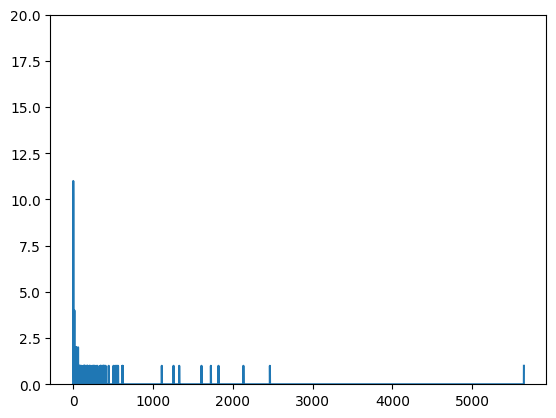

In [576]:
# POCTY BODOV V ZHLUKOCH BEZ ZHLUKU -1
najvacsie_po_najmensie = sorted(pocty,key=lambda x: x[1],reverse=True)
najvacsie = najvacsie_po_najmensie[0][1]
pocty_clustrov = np.zeros(najvacsie)
for index,pocet in enumerate(pocty):
   pocty_clustrov[pocet[1] -1]+=1
#pocty_clustrov_pre_body.append((i, labels.tolist().count(i)))
plt.figure()
plt.plot(range(len(pocty_clustrov)),pocty_clustrov)
plt.ylim(0,20)
plt.show()